Data retrieved from frost.met.no!
                       elementId  value  unit  \
0      mean(air_temperature P1D)    3.2  degC   
1      mean(air_temperature P1D)    3.0  degC   
2  sum(precipitation_amount P1D)   13.5    mm   
3  sum(precipitation_amount P1D)   29.0    mm   
4           mean(wind_speed P1D)    1.7   m/s   

                                               level timeOffset  \
0  {'levelType': 'height_above_ground', 'unit': '...       PT0H   
1  {'levelType': 'height_above_ground', 'unit': '...       PT6H   
2                                                NaN      PT18H   
3                                                NaN       PT6H   
4  {'levelType': 'height_above_ground', 'unit': '...       PT0H   

  timeResolution  timeSeriesId performanceCategory exposureCategory  \
0            P1D             0                   C                2   
1            P1D             0                   C                2   
2            P1D             0                   C     

/var/folders/2y/z0z72b8534j68rb81zfyqw_c0000gn/T/ipykernel_2057/77004569.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
/var/folders/2y/z0z72b8534j68rb81zfyqw_c0000gn/T/ipykernel_2057/77004569.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
/var/folders/2y/z0z72b8534j68rb81zfyqw_c0000gn/T/ipykernel_2057/77004569.py:54: Sett

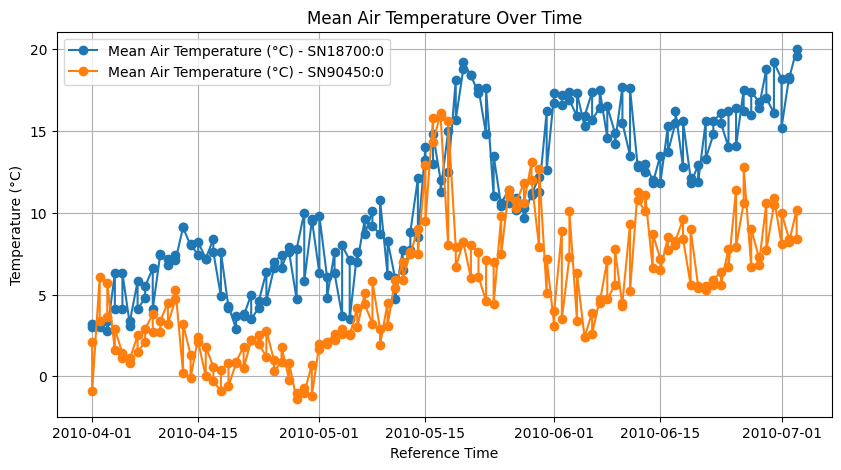

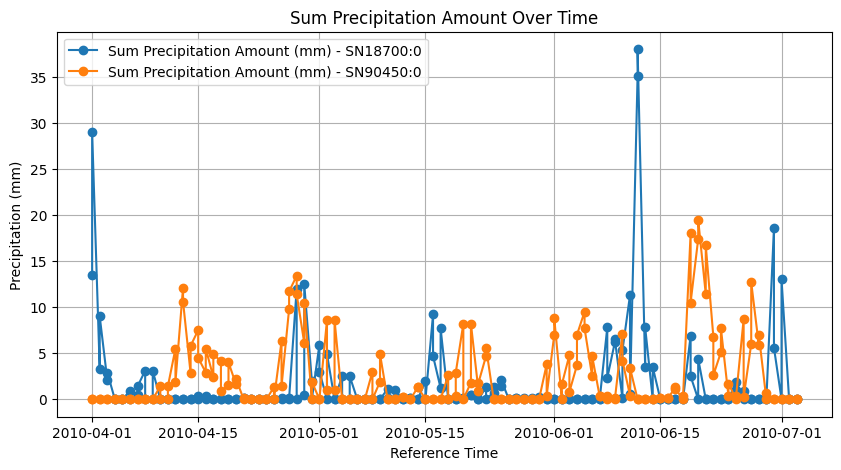

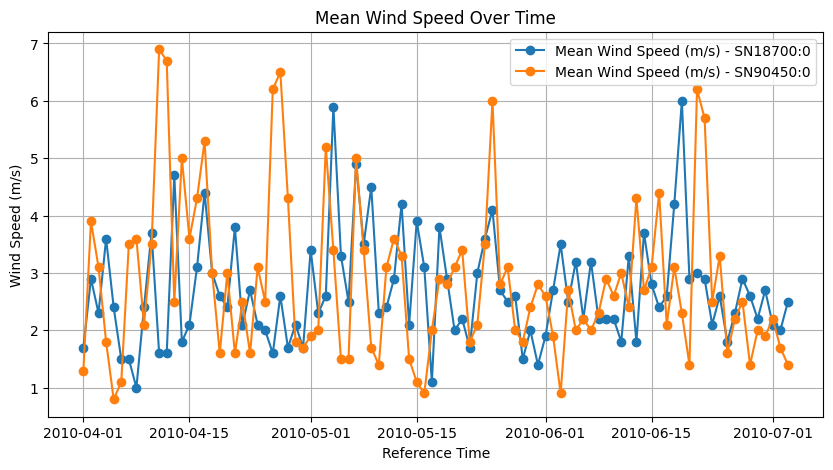

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Insert your own client ID here
client_id = '2e243d34-57bc-42b4-8095-239991af5353'
# Define endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN18700,SN90450',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    'referencetime': '2010-04-01/2010-07-04',
}
# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

important_keys = ['elementId', 'value', 'unit', 'timeOffset', 'timeResolution', 'qualityCode']

# Collect the important data into a list of dictionaries
df_list = []

for item in data:
    row = pd.DataFrame(item['observations'])
    row['referenceTime'] = item['referenceTime']
    row['sourceId'] = item['sourceId']
    df_list.append(row)

# Efficiently concatenate all DataFrames at once
df = pd.concat(df_list, ignore_index=True)

# Display the DataFrame
print(df.head())

# Plotting the data
# Separate the data by elementId
temperature_data = df[df['elementId'] == 'mean(air_temperature P1D)']
precipitation_data = df[df['elementId'] == 'sum(precipitation_amount P1D)']
wind_speed_data = df[df['elementId'] == 'mean(wind_speed P1D)']

# Convert referencetime to datetime
temperature_data['referenceTime'] = pd.to_datetime(temperature_data['referenceTime'])
precipitation_data['referenceTime'] = pd.to_datetime(precipitation_data['referenceTime'])
wind_speed_data['referenceTime'] = pd.to_datetime(wind_speed_data['referenceTime'])

# Plot mean air temperature
plt.figure(figsize=(10, 5))
for source_id, group in temperature_data.groupby('sourceId'):
    plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Air Temperature (°C) - {source_id}')
plt.xlabel('Reference Time')
plt.ylabel('Temperature (°C)')
plt.title('Mean Air Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot sum precipitation amount
plt.figure(figsize=(10, 5))
for source_id, group in precipitation_data.groupby('sourceId'):
    plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Sum Precipitation Amount (mm) - {source_id}')
plt.xlabel('Reference Time')
plt.ylabel('Precipitation (mm)')
plt.title('Sum Precipitation Amount Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot mean wind speed
plt.figure(figsize=(10, 5))
for source_id, group in wind_speed_data.groupby('sourceId'):
    plt.plot(group['referenceTime'], group['value'], marker='o', label=f'Mean Wind Speed (m/s) - {source_id}')
plt.xlabel('Reference Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Mean Wind Speed Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(df)

                         elementId  value  unit  \
0        mean(air_temperature P1D)    3.2  degC   
1        mean(air_temperature P1D)    3.0  degC   
2    sum(precipitation_amount P1D)   13.5    mm   
3    sum(precipitation_amount P1D)   29.0    mm   
4             mean(wind_speed P1D)    1.7   m/s   
..                             ...    ...   ...   
325      mean(air_temperature P1D)    2.6  degC   
326      mean(air_temperature P1D)    2.2  degC   
327  sum(precipitation_amount P1D)    1.0    mm   
328  sum(precipitation_amount P1D)    8.6    mm   
329           mean(wind_speed P1D)    5.2   m/s   

                                                 level timeOffset  \
0    {'levelType': 'height_above_ground', 'unit': '...       PT0H   
1    {'levelType': 'height_above_ground', 'unit': '...       PT6H   
2                                                  NaN      PT18H   
3                                                  NaN       PT6H   
4    {'levelType': 'height_above_ground', 